# Small Project
This notebook will be our report.

(Hui Kang should not be editing this anymore. All the best!)

# Data analysis

### Dataloader and Input Sampling

We use a common dataloader for all datasets.

There are 9 combinations (train, test, val) crossed with (the triclass classification and two binary classifiers). Therefore, it makes sense to create an class to generalise the possible dataloaders that we need.

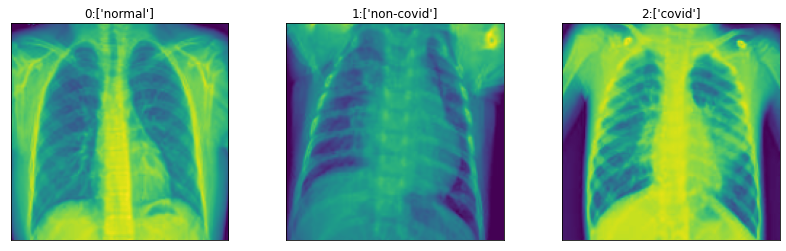

In [1]:
from lung_dataset import Lung_Dataset
ld_train = Lung_Dataset("test", "normal/non-covid/covid")
ld_train.show_imgs([0, 301, -1])

### Class distribution
We present the class distribution in a pie chart so that we can visualise the differences in the relative proportion.

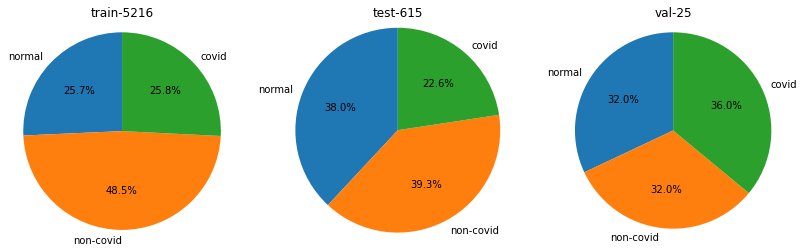

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, nrows=1, squeeze=False, figsize=(14,4))
for i,data_split in enumerate(["train", "test", "val"]):

    ld = Lung_Dataset(data_split, "normal/non-covid/covid")
    labels = [class_[0] for class_ in ld.classes]
    sizes = ld.class_distbn

    ax[0][i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax[0][i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[0][i].set_title("{}-{}".format(data_split, sum(sizes)))

plt.show()

# Preprocessing

### Data augmentation

We apply random rotation in our data augmentation. X-ray are not always taken vertically, as we noticed that some of the images are slightly rotated. Random rotation between -5 to 5 degrees will simulate such a variation.

Adding randomness in the training data helps to tackle overfitting. It was observed that after data augmentation, for models without dropout, the training accuracy no longer approaches near 100%.

We have considered the following data augmentation methods and decided not to apply them, and the reasons are justified as such
- Noising. We might want the model to detect specks in the X-rays, and noising may cause this feature to be undetectable.
- Random cropping. We tried this and it resulted in predictions that are hardly better than random.
- Flipping. The X-ray is not exactly symmetrical due to the placement of the heart, we do not want to train the model to be agnostic to the orientation.


### Data processing

We crop and resize for both our training and testing set. The center 140 pixels are cropped, and then resized back to 150 pixels. The purpose is to exclude the misfited pixels due to the rotation operation. Moreover, whether the lung is infected should not depend on the pixels at the border as the position of the lung is in the middle of the picture.

The latter resizing operation is actually unnecessary, but we retained it for the ease of development. We want to standardise the dimensions of our input to be the same as our original dataset.


### Data Normalisation

From the sample code, the 8-bit picture has scaled down to 0 to 1. We calculated the mean and standard deviation of the dataset, which was 0.482 and 0.236. With the mean and standard deviation, we apply normalisation transformation to all data splits.

Normalising the input is said to help to train the model [faster](https://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network).

### Full Preprocessing Step


```python
        if self.data_split == "train":
            transform = transforms.Compose([
                transforms.RandomRotation((-5,5)),
            ])
            im = transform(im)
            
        transform = transforms.Compose([
                transforms.CenterCrop((140)),
                transforms.Resize((150)),
            ])
        im = transform(im)

        im = transforms.Normalize(mean=0.482, std=0.236)(im)
```


The normalisation is executed after the rotation. We decided this order because we want the misfitted pixels (if there is remaining) resulting from the rotation to remain dark.

train


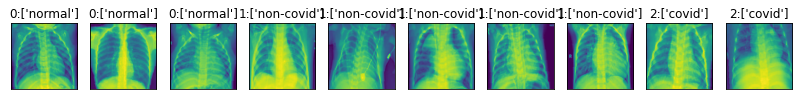

test


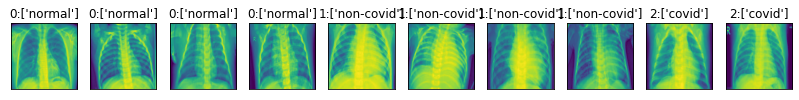

In [3]:
from lung_dataset import Lung_Dataset
print("train")
ld_train = Lung_Dataset("train", "normal/non-covid/covid")
ld_train.show_imgs(range(0,5000,500))

print("test")
ld_train = Lung_Dataset("test", "normal/non-covid/covid")
ld_train.show_imgs(range(0,660,66))

# Model Design

We will now explain our model design. There are several components that we decide research.

### Loss Function - Cross Entropy Loss (to tired to write a better explanation)

We use a logloss function because this is a multiclass classification. We want to produce classification, and logloss rewards highly confident predictions solutions and punishes highly confident wrong predictions. The logits go through a softmax layers to produces probabilities.

### Triclass classifier instead of two binary classifiers

The problem statement proposed two ways that we are train our model 
- a single triclass classifier classifying between normal/non-covid/covid
- two binary classifiers, with the first classifying between normal/infected and the second classifier classifying non-covid/covid

We decided to focus only on a three-class classifiers for the ease of development, as well as the lack of foreseeable benefits from the two binary classifiers.

Two binary classifier does not seem to provide significant benefits over the triclass classifier
- The accuracy of the two binary classifier is not signficantly better than the triclass classifier.
- We might be interested in the questions that that the two binary classifiers answers, such as the probability of either infection or the probability of covid given that it is infected. However, we can calculate this with the ratio of probabilities produced by the triclass classifier.


### Model Hyperparameters

We will use grid search to find the best model hyperparameters for the above choices.


#### Model architecture (please elaborate)

- types of layers, number of layers (and thus the number of parameters)

There is a tradeoff of having a model with a larger number of parameter. A general rule of machine is that the number of parameters should be less than the amount of dataset. Our training dataset is of size 5856 pictures. 

Custom1(5 conv layers), Custom2(7 conv layer), ResNet

activation function: ReLu as a start, log_softmax at the end


#### Mini-batch size (please elaborate)

We increased the batch-size from the default value of 4 to 16 to allow for batch-normalisation. (please try and find the exact value)

A mini-batch too small
- Results in slower training as more computations could be done in parallel
- Batch normalisation does not work for small mini-batches

A mini-batch too large
- The GPU may not have sufficient memory
- Gradients are updated too slowly

 
#### Optimizer and learning rate (please elaborate)

Adam (lr[0.01,0.05,...], momentum)
We chose the default optimiser because

A learning rate too large may not converge, a learning rate too small converges too slowly.

Learning rate scheduler (bonus)

#### Others

Regularisation (bonus)

Weights Initialisation

### Hyperparameters Search

We use grid search to find the best combination of the model hyperparameters.

The best set of parameters are

# Performance evaluation

### Visualisation on the validation set

We show how did we predict on the visualisation set

normal


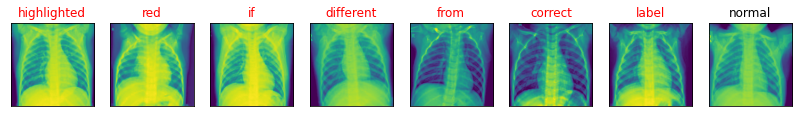

non-covid


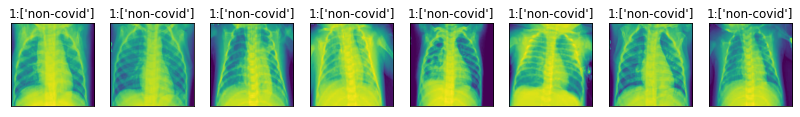

covid


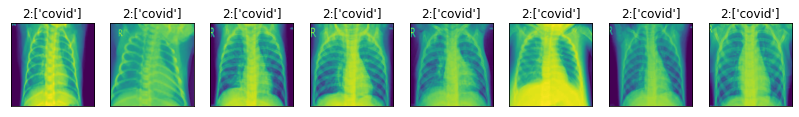

In [4]:
print("normal")
ld_train = Lung_Dataset("val", "normal/non-covid/covid")
ld_train.show_imgs(range(0,8), titles=["highlighted", "red", "if", "different", "from", "correct", "label", "normal"])

print("non-covid")
ld_train = Lung_Dataset("val", "normal/non-covid/covid")
ld_train.show_imgs(range(8,16))

print("covid")
ld_train = Lung_Dataset("val", "normal/non-covid/covid")
ld_train.show_imgs(range(16,24))

### Performance Metrics (please elaborate)

(on our proposed model)
- train while test model while showing metrics
- show examples of performance - validation set and typical samples of failure
- confusion matrix
- justification on metrics selected (yuxiang and shiying please justify)

### Evaluation Method (change accuracy to something)

As the accuracy of the test set does not converge, we use the average accuracy of the last 10 epochs.

We considered a few alternatives of evaluation the accuracy of the model
- Taking the best accuracy across all epochs trained. Each accuracy of the model can be modelled a sample of a random variable, which may or may not be stationary. More training iterations usually improve the best accuracy even though the mean of the real accuracy may be unchanged or even worsened.
- Spliting the test set into two, taking the model with the best accuracy on the first test set and applying on the second test set. The accuracy on the second test set is just one sample of the random variable, which may be inaccurate.

Taking the average accuracy of the last 10 epoch will be a more accurate estiate of the true accuracy of the model on modelled true data distribution.